In [17]:
import torch
import numpy as np
import matplotlib.pyplot as plt

# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

In [18]:
# Graph with 4 nodes
# Node 0 -- Node 1
#   |         |
# Node 2 -- Node 3

# Node features (4 nodes, 2 features each)
X = torch.tensor([
    [1.0, 0.0],   # Node 0: Class 0 features
    [0.8, 0.2],   # Node 1: Class 0 features
    [0.0, 1.0],   # Node 2: Class 1 features
    [0.2, 0.8],   # Node 3: Class 1 features
], dtype=torch.float32)

# Node labels (binary classification)
y = torch.tensor([0, 0, 1, 1], dtype=torch.float32)

# Edge list: (source, target)
edges = [
    (0, 1), (1, 0),  # Node 0 -- Node 1
    (0, 2), (2, 0),  # Node 0 -- Node 2
    (1, 3), (3, 1),  # Node 1 -- Node 3
    (2, 3), (3, 2),  # Node 2 -- Node 3
]

# Adjacency matrix (4x4)
num_nodes = 4
A = torch.zeros(num_nodes, num_nodes)
for src, tgt in edges:
    A[src, tgt] = 1.0

# Add self-loops (node connects to itself)
A_hat = A + torch.eye(num_nodes)

print("Node Features X:")
print(X)
print(f"\nNode Labels: {y.tolist()}")
print("\nAdjacency Matrix A (with self-loops):")
print(A_hat)

Node Features X:
tensor([[1.0000, 0.0000],
        [0.8000, 0.2000],
        [0.0000, 1.0000],
        [0.2000, 0.8000]])

Node Labels: [0.0, 0.0, 1.0, 1.0]

Adjacency Matrix A (with self-loops):
tensor([[1., 1., 1., 0.],
        [1., 1., 0., 1.],
        [1., 0., 1., 1.],
        [0., 1., 1., 1.]])


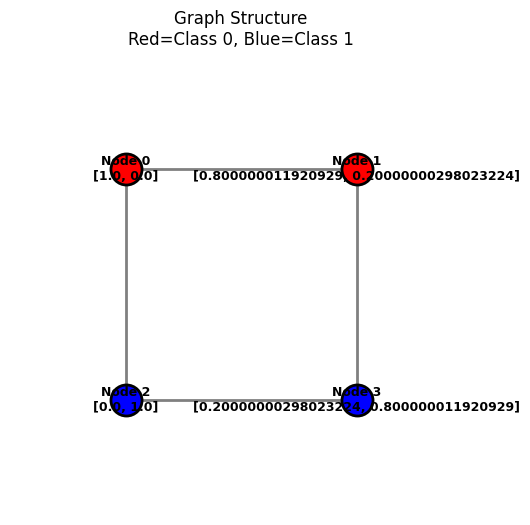

In [19]:
def visualize_graph(X, edges, labels):
    """Visualize graph with nodes and edges."""
    fig, ax = plt.subplots(figsize=(8, 6))
    
    # Node positions (manual layout)
    positions = {
        0: (0, 1),
        1: (1, 1),
        2: (0, 0),
        3: (1, 0),
    }
    
    # Draw edges
    drawn_edges = set()
    for src, tgt in edges:
        if (tgt, src) not in drawn_edges:  # Avoid drawing twice
            x1, y1 = positions[src]
            x2, y2 = positions[tgt]
            ax.plot([x1, x2], [y1, y2], 'gray', linewidth=2, zorder=1)
            drawn_edges.add((src, tgt))
    
    # Draw nodes
    colors = ['red' if l == 0 else 'blue' for l in labels]
    for node_id, (x, y) in positions.items():
        ax.scatter(x, y, c=colors[node_id], s=500, zorder=2, edgecolors='black', linewidth=2)
        ax.annotate(f'Node {node_id}\n{X[node_id].tolist()}', (x, y), 
                   ha='center', va='center', fontsize=9, fontweight='bold')
    
    ax.set_xlim(-0.5, 1.5)
    ax.set_ylim(-0.5, 1.5)
    ax.set_aspect('equal')
    ax.set_title('Graph Structure\nRed=Class 0, Blue=Class 1')
    ax.axis('off')
    plt.show()

visualize_graph(X, edges, y)

In [20]:
def compute_normalized_adjacency(A_hat):
    """
    Compute normalized adjacency matrix.
    A_norm = D^(-1/2) * A_hat * D^(-1/2)
    """
    # Compute degree matrix D
    D = torch.sum(A_hat, dim=1)  # Sum of each row
    
    # D^(-1/2)
    D_inv_sqrt = torch.diag(1.0 / torch.sqrt(D))
    
    # Normalized adjacency
    A_norm = torch.matmul(torch.matmul(D_inv_sqrt, A_hat), D_inv_sqrt)
    
    return A_norm, D

A_norm, D = compute_normalized_adjacency(A_hat)

print("Degree of each node:")
print(D)
print("\nNormalized Adjacency Matrix:")
print(A_norm)

Degree of each node:
tensor([3., 3., 3., 3.])

Normalized Adjacency Matrix:
tensor([[0.3333, 0.3333, 0.3333, 0.0000],
        [0.3333, 0.3333, 0.0000, 0.3333],
        [0.3333, 0.0000, 0.3333, 0.3333],
        [0.0000, 0.3333, 0.3333, 0.3333]])


In [21]:
def graph_conv(H, A_norm, W, b):
    """
    Graph Convolution Layer.
    
    H' = A_norm @ H @ W + b
    
    Args:
        H: Node features (num_nodes, in_features)
        A_norm: Normalized adjacency (num_nodes, num_nodes)
        W: Weight matrix (in_features, out_features)
        b: Bias vector (out_features,)
    
    Returns:
        H': Updated node features (num_nodes, out_features)
    """
    # Step 1: Aggregate neighbor features using adjacency
    # A_norm @ H: For each node, sum of normalized neighbor features
    aggregated = torch.matmul(A_norm, H)
    
    # Step 2: Linear transformation
    # aggregated @ W + b: Project to new feature space
    H_new = torch.matmul(aggregated, W) + b
    
    return H_new

print("Graph Convolution function defined!")
print("\nHow it works:")
print("1. A_norm @ H: Aggregate features from neighbors")
print("2. @ W + b: Linear transformation")

Graph Convolution function defined!

How it works:
1. A_norm @ H: Aggregate features from neighbors
2. @ W + b: Linear transformation


In [22]:
def visualize_message_passing(node_id, X, A_norm):
    """Show how a node aggregates features from neighbors."""
    print(f"Message Passing for Node {node_id}")
    print("="*50)
    
    # Get weights for this node from normalized adjacency
    weights = A_norm[node_id]
    
    print(f"\nNode {node_id} original features: {X[node_id].tolist()}")
    print(f"\nAggregation weights from A_norm[{node_id}]: {weights.tolist()}")
    print("\nMessages received:")
    
    aggregated = torch.zeros_like(X[0])
    for i in range(len(X)):
        if weights[i] > 0:
            message = weights[i] * X[i]
            aggregated += message
            print(f"  From Node {i}: weight={weights[i]:.3f} × features={X[i].tolist()} = {message.tolist()}")
    
    print(f"\nAggregated features: {aggregated.tolist()}")
    return aggregated

# Show message passing for Node 0
agg_0 = visualize_message_passing(0, X, A_norm)

Message Passing for Node 0

Node 0 original features: [1.0, 0.0]

Aggregation weights from A_norm[0]: [0.3333333134651184, 0.3333333134651184, 0.3333333134651184, 0.0]

Messages received:
  From Node 0: weight=0.333 × features=[1.0, 0.0] = [0.3333333134651184, 0.0]
  From Node 1: weight=0.333 × features=[0.800000011920929, 0.20000000298023224] = [0.2666666507720947, 0.06666666269302368]
  From Node 2: weight=0.333 × features=[0.0, 1.0] = [0.0, 0.3333333134651184]

Aggregated features: [0.5999999642372131, 0.3999999761581421]


In [23]:
def relu(x):
    """ReLU activation: max(0, x)"""
    return torch.maximum(x, torch.tensor(0.0))

def relu_derivative(x):
    """Derivative of ReLU"""
    return (x > 0).float()

def sigmoid(x):
    """Sigmoid activation"""
    return 1 / (1 + torch.exp(-torch.clamp(x, -50, 50)))

print("Activation functions defined!")

Activation functions defined!


In [24]:
# GNN Architecture
in_features = 2
hidden_features = 4
out_features = 1

def init_gnn_weights():
    """Initialize GNN weights."""
    weights = {
        # Layer 1: 2 -> 4
        'W1': torch.randn(in_features, hidden_features) * 0.5,
        'b1': torch.zeros(hidden_features),
        # Layer 2: 4 -> 1
        'W2': torch.randn(hidden_features, out_features) * 0.5,
        'b2': torch.zeros(out_features),
    }
    return weights

weights = init_gnn_weights()

print("GNN Architecture:")
print(f"  Input:  {in_features} features per node")
print(f"  Hidden: {hidden_features} features per node")
print(f"  Output: {out_features} feature per node")
print(f"\nWeight shapes:")
for k, v in weights.items():
    print(f"  {k}: {v.shape}")

GNN Architecture:
  Input:  2 features per node
  Hidden: 4 features per node
  Output: 1 feature per node

Weight shapes:
  W1: torch.Size([2, 4])
  b1: torch.Size([4])
  W2: torch.Size([4, 1])
  b2: torch.Size([1])


In [25]:
def gnn_forward(X, A_norm, weights):
    """
    GNN forward pass.
    
    Args:
        X: Node features (num_nodes, in_features)
        A_norm: Normalized adjacency matrix
        weights: Dictionary of weights
    
    Returns:
        predictions: Node predictions (num_nodes, 1)
        cache: Values for backprop
    """
    # Layer 1: Graph Convolution + ReLU
    Z1 = graph_conv(X, A_norm, weights['W1'], weights['b1'])
    H1 = relu(Z1)
    
    # Layer 2: Graph Convolution + Sigmoid
    Z2 = graph_conv(H1, A_norm, weights['W2'], weights['b2'])
    predictions = sigmoid(Z2)
    
    # Store cache for backprop
    cache = {
        'X': X,
        'Z1': Z1,
        'H1': H1,
        'Z2': Z2,
    }
    
    return predictions, cache

# Test forward pass
pred, cache = gnn_forward(X, A_norm, weights)

print("Forward Pass:")
print(f"  Input X shape: {X.shape}")
print(f"  Hidden H1 shape: {cache['H1'].shape}")
print(f"  Predictions shape: {pred.shape}")
print(f"\nInitial predictions:")
for i in range(num_nodes):
    print(f"  Node {i}: {pred[i].item():.4f}")

Forward Pass:
  Input X shape: torch.Size([4, 2])
  Hidden H1 shape: torch.Size([4, 4])
  Predictions shape: torch.Size([4, 1])

Initial predictions:
  Node 0: 0.5372
  Node 1: 0.5387
  Node 2: 0.5444
  Node 3: 0.5431


In [26]:
def binary_cross_entropy(y_true, y_pred):
    """Binary Cross-Entropy Loss."""
    epsilon = 1e-7
    y_pred = torch.clamp(y_pred.squeeze(), epsilon, 1 - epsilon)
    loss = -torch.mean(y_true * torch.log(y_pred) + (1 - y_true) * torch.log(1 - y_pred))
    return loss

# Test loss
loss = binary_cross_entropy(y, pred)
print(f"Initial Loss: {loss.item():.4f}")

Initial Loss: 0.6907


In [27]:
def gnn_backward(y_true, y_pred, cache, weights, A_norm):
    """
    GNN backward pass.
    
    Compute gradients for all weights.
    """
    num_nodes = y_true.shape[0]
    
    # Initialize gradients
    grads = {
        'W1': torch.zeros_like(weights['W1']),
        'b1': torch.zeros_like(weights['b1']),
        'W2': torch.zeros_like(weights['W2']),
        'b2': torch.zeros_like(weights['b2']),
    }
    
    # === Output Layer Gradient ===
    # d_loss/d_Z2 = y_pred - y_true (for BCE with sigmoid)
    dZ2 = (y_pred.squeeze() - y_true).unsqueeze(1) / num_nodes  # (num_nodes, 1)
    
    # === Layer 2 Gradients ===
    # Z2 = A_norm @ H1 @ W2 + b2
    # d_loss/d_W2 = (A_norm @ H1)^T @ dZ2
    AH1 = torch.matmul(A_norm, cache['H1'])  # Aggregated H1
    grads['W2'] = torch.matmul(AH1.T, dZ2)
    grads['b2'] = torch.sum(dZ2, dim=0)
    
    # d_loss/d_H1 = A_norm^T @ dZ2 @ W2^T
    dH1 = torch.matmul(torch.matmul(A_norm.T, dZ2), weights['W2'].T)
    
    # === ReLU Gradient ===
    dZ1 = dH1 * relu_derivative(cache['Z1'])
    
    # === Layer 1 Gradients ===
    # Z1 = A_norm @ X @ W1 + b1
    AX = torch.matmul(A_norm, cache['X'])  # Aggregated X
    grads['W1'] = torch.matmul(AX.T, dZ1)
    grads['b1'] = torch.sum(dZ1, dim=0)
    
    return grads

print("GNN backward pass defined!")

GNN backward pass defined!


In [28]:
# Hyperparameters
learning_rate = 1.0
epochs = 200

# Re-initialize weights
torch.manual_seed(42)
weights = init_gnn_weights()

# Store losses
losses = []

print("Training GNN...")
print("="*50)

for epoch in range(epochs):
    # Forward pass
    predictions, cache = gnn_forward(X, A_norm, weights)
    
    # Compute loss
    loss = binary_cross_entropy(y, predictions)
    losses.append(loss.item())
    
    # Backward pass
    grads = gnn_backward(y, predictions, cache, weights, A_norm)
    
    # Update weights
    for key in weights:
        weights[key] = weights[key] - learning_rate * grads[key]
    
    if epoch % 20 == 0:
        print(f"Epoch {epoch:4d} | Loss: {loss.item():.6f}")

print(f"\nFinal Loss: {losses[-1]:.6f}")

Training GNN...
Epoch    0 | Loss: 0.690722
Epoch   20 | Loss: 0.675073
Epoch   40 | Loss: 0.636382
Epoch   60 | Loss: 0.566084
Epoch   80 | Loss: 0.474570
Epoch  100 | Loss: 0.378565
Epoch  120 | Loss: 0.730312
Epoch  140 | Loss: 0.284859
Epoch  160 | Loss: 0.540272
Epoch  180 | Loss: 0.195247

Final Loss: 0.165812


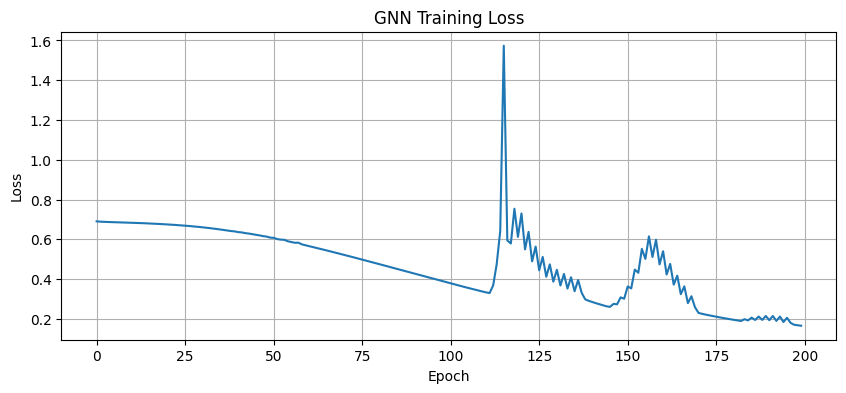

In [29]:
plt.figure(figsize=(10, 4))
plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('GNN Training Loss')
plt.grid(True)
plt.show()

In [30]:
print("Node Classification Results:")
print("="*60)
print(f"{'Node':<8} {'True Label':<12} {'Predicted':<12} {'Rounded':<10}")
print("-"*60)

predictions, _ = gnn_forward(X, A_norm, weights)

correct = 0
for i in range(num_nodes):
    true_label = int(y[i].item())
    pred_prob = predictions[i].item()
    pred_label = 1 if pred_prob > 0.5 else 0
    correct += (pred_label == true_label)
    
    print(f"Node {i:<4} {true_label:<12} {pred_prob:<12.4f} {pred_label:<10}")

print(f"\nAccuracy: {correct}/{num_nodes} = {100*correct/num_nodes:.1f}%")
print("\n✓ GNN has learned to classify nodes based on graph structure!")

Node Classification Results:
Node     True Label   Predicted    Rounded   
------------------------------------------------------------
Node 0    0            0.1123       0         
Node 1    0            0.2718       0         
Node 2    1            0.8967       1         
Node 3    1            0.8967       1         

Accuracy: 4/4 = 100.0%

✓ GNN has learned to classify nodes based on graph structure!


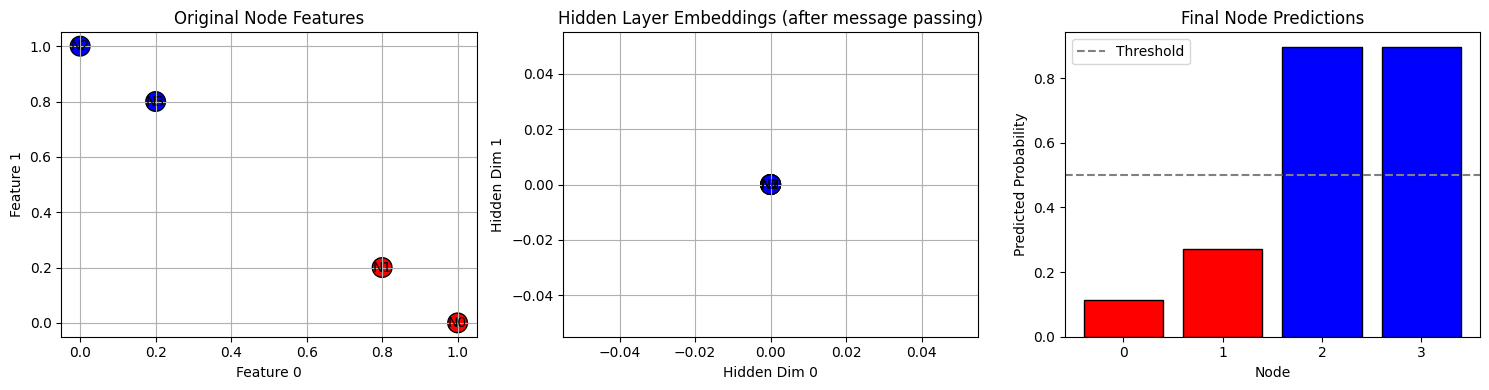

In [31]:
def visualize_embeddings(X, cache, predictions, y):
    """Visualize node embeddings before and after GNN."""
    fig, axes = plt.subplots(1, 3, figsize=(15, 4))
    
    colors = ['red' if label == 0 else 'blue' for label in y]
    
    # Original features
    axes[0].scatter(X[:, 0].numpy(), X[:, 1].numpy(), c=colors, s=200, edgecolors='black')
    for i in range(len(X)):
        axes[0].annotate(f'N{i}', (X[i, 0].item(), X[i, 1].item()), ha='center', va='center')
    axes[0].set_xlabel('Feature 0')
    axes[0].set_ylabel('Feature 1')
    axes[0].set_title('Original Node Features')
    axes[0].grid(True)
    
    # Hidden embeddings (first 2 dims)
    H1 = cache['H1'].detach().numpy()
    axes[1].scatter(H1[:, 0], H1[:, 1], c=colors, s=200, edgecolors='black')
    for i in range(len(H1)):
        axes[1].annotate(f'N{i}', (H1[i, 0], H1[i, 1]), ha='center', va='center')
    axes[1].set_xlabel('Hidden Dim 0')
    axes[1].set_ylabel('Hidden Dim 1')
    axes[1].set_title('Hidden Layer Embeddings (after message passing)')
    axes[1].grid(True)
    
    # Final predictions
    pred_np = predictions.detach().numpy().squeeze()
    axes[2].bar(range(4), pred_np, color=colors, edgecolor='black')
    axes[2].axhline(y=0.5, color='gray', linestyle='--', label='Threshold')
    axes[2].set_xlabel('Node')
    axes[2].set_ylabel('Predicted Probability')
    axes[2].set_title('Final Node Predictions')
    axes[2].set_xticks(range(4))
    axes[2].legend()
    
    plt.tight_layout()
    plt.show()

predictions, cache = gnn_forward(X, A_norm, weights)
visualize_embeddings(X, cache, predictions, y)

In [32]:
print("How GNN uses graph structure:")
print("="*60)
print("\nNode 0 is connected to: Node 1 (same class), Node 2 (diff class)")
print("Node 3 is connected to: Node 1 (diff class), Node 2 (same class)")
print("\nThe GNN learns to aggregate neighbor information")
print("and classify nodes based on both their features AND neighbors.")

print("\n" + "="*60)
print("Layer 1 aggregation (input -> hidden):")
for i in range(num_nodes):
    neighbors = [j for j in range(num_nodes) if A_hat[i, j] > 0]
    print(f"  Node {i} aggregates from: {neighbors}")

print("\nLayer 2 aggregation (hidden -> output):")
print("  Same aggregation pattern, but on hidden features")
print("  2-hop neighbors influence final prediction!")

How GNN uses graph structure:

Node 0 is connected to: Node 1 (same class), Node 2 (diff class)
Node 3 is connected to: Node 1 (diff class), Node 2 (same class)

The GNN learns to aggregate neighbor information
and classify nodes based on both their features AND neighbors.

Layer 1 aggregation (input -> hidden):
  Node 0 aggregates from: [0, 1, 2]
  Node 1 aggregates from: [0, 1, 3]
  Node 2 aggregates from: [0, 2, 3]
  Node 3 aggregates from: [1, 2, 3]

Layer 2 aggregation (hidden -> output):
  Same aggregation pattern, but on hidden features
  2-hop neighbors influence final prediction!
